### Imports

In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear, LazyLinear, Sequential, BatchNorm1d, ReLU

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero, LightGCN

import pathlib
import os
import sys
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))
from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.visualize import plot_loss, plot_test
from utils.minibatches_split import split_to_minibatches
from utils.train_test import train_test, train_test_mini_batch

import matplotlib.pyplot as plt


### Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title", "original_title"],
    list_features=[],
    fastRP_features=[],
    numeric_features=[],
    node2vec_features=[],
    SAGE_features=[],
)

# path = osp.join('../../data/MovieLens')
# dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

data = dataset[0].to(device)
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes
# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

Processing...


Movies have features...
Encoding title...
Encoding original_title...
[torch.Size([9067, 384]), torch.Size([9067, 384])]


Done!


### Train test functions

In [10]:
latest_predictions = []
losses_ = {}

train_batch, train_loader = split_to_minibatches(
    data=train_data,
    batch_size=512,
    num_neighbours=[15, 10, 5],
)
test_batch, test_loader = split_to_minibatches(
    data=test_data,
    batch_size=512,
    num_neighbours=[15, 10, 5],
)


### Experiments

In [11]:
model = Model(layer_name="SAGE", hidden_channels=32, data=data, encoder_num_layers=3,
              decoder_num_layers=4, encoder_dropout=0.5, encoder_skip_connections=1)

losses_["lala"] = train_test_mini_batch(
    model=model,
    epochs=100,
    train_batch=train_batch,
    train_loader=train_loader,
    test_batch=test_batch,
    test_loader=test_loader,
    lr=0.012,
)


SAGE
Aggregation: None


  1%|▏         | 2/156 [00:00<00:07, 19.86it/s]

		 Train Batch: Loss: 21.8867


 67%|██████▋   | 104/156 [00:04<00:02, 21.62it/s]

		 Train Batch: Loss: 19.8765


 30%|███       | 6/20 [00:00<00:00, 24.60it/s]

		 Test Batch: Loss: 3.5876


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Epoch: 001, Loss: 21.9776, Test: 3.5885


  2%|▏         | 3/156 [00:00<00:06, 22.39it/s]

		 Train Batch: Loss: 23.2185


 67%|██████▋   | 105/156 [00:04<00:02, 23.19it/s]

		 Train Batch: Loss: 21.8746


 30%|███       | 6/20 [00:00<00:00, 26.50it/s]

		 Test Batch: Loss: 3.5658


100%|██████████| 20/20 [00:00<00:00, 26.84it/s]


Epoch: 002, Loss: 21.9774, Test: 3.5900


  2%|▏         | 3/156 [00:00<00:06, 22.05it/s]

		 Train Batch: Loss: 21.4996


 67%|██████▋   | 105/156 [00:04<00:02, 23.17it/s]

		 Train Batch: Loss: 19.6966


 30%|███       | 6/20 [00:00<00:00, 25.30it/s]

		 Test Batch: Loss: 3.5860


100%|██████████| 20/20 [00:00<00:00, 26.14it/s]


Epoch: 003, Loss: 21.9775, Test: 3.5923


  2%|▏         | 3/156 [00:00<00:06, 22.06it/s]

		 Train Batch: Loss: 21.4659


 67%|██████▋   | 105/156 [00:04<00:02, 23.15it/s]

		 Train Batch: Loss: 22.2540


 30%|███       | 6/20 [00:00<00:00, 25.99it/s]

		 Test Batch: Loss: 3.6099


100%|██████████| 20/20 [00:00<00:00, 26.18it/s]


Epoch: 004, Loss: 21.9773, Test: 3.5936


  2%|▏         | 3/156 [00:00<00:06, 22.55it/s]

		 Train Batch: Loss: 22.5469


 67%|██████▋   | 105/156 [00:04<00:02, 22.79it/s]

		 Train Batch: Loss: 21.5468


 30%|███       | 6/20 [00:00<00:00, 26.51it/s]

		 Test Batch: Loss: 3.5732


100%|██████████| 20/20 [00:00<00:00, 26.53it/s]


Epoch: 005, Loss: 21.9772, Test: 3.5922


  2%|▏         | 3/156 [00:00<00:06, 22.25it/s]

		 Train Batch: Loss: 22.7543


 65%|██████▌   | 102/156 [00:04<00:02, 21.34it/s]

		 Train Batch: Loss: 22.5039


 90%|████████▉ | 140/156 [00:06<00:00, 21.71it/s]


KeyboardInterrupt: 

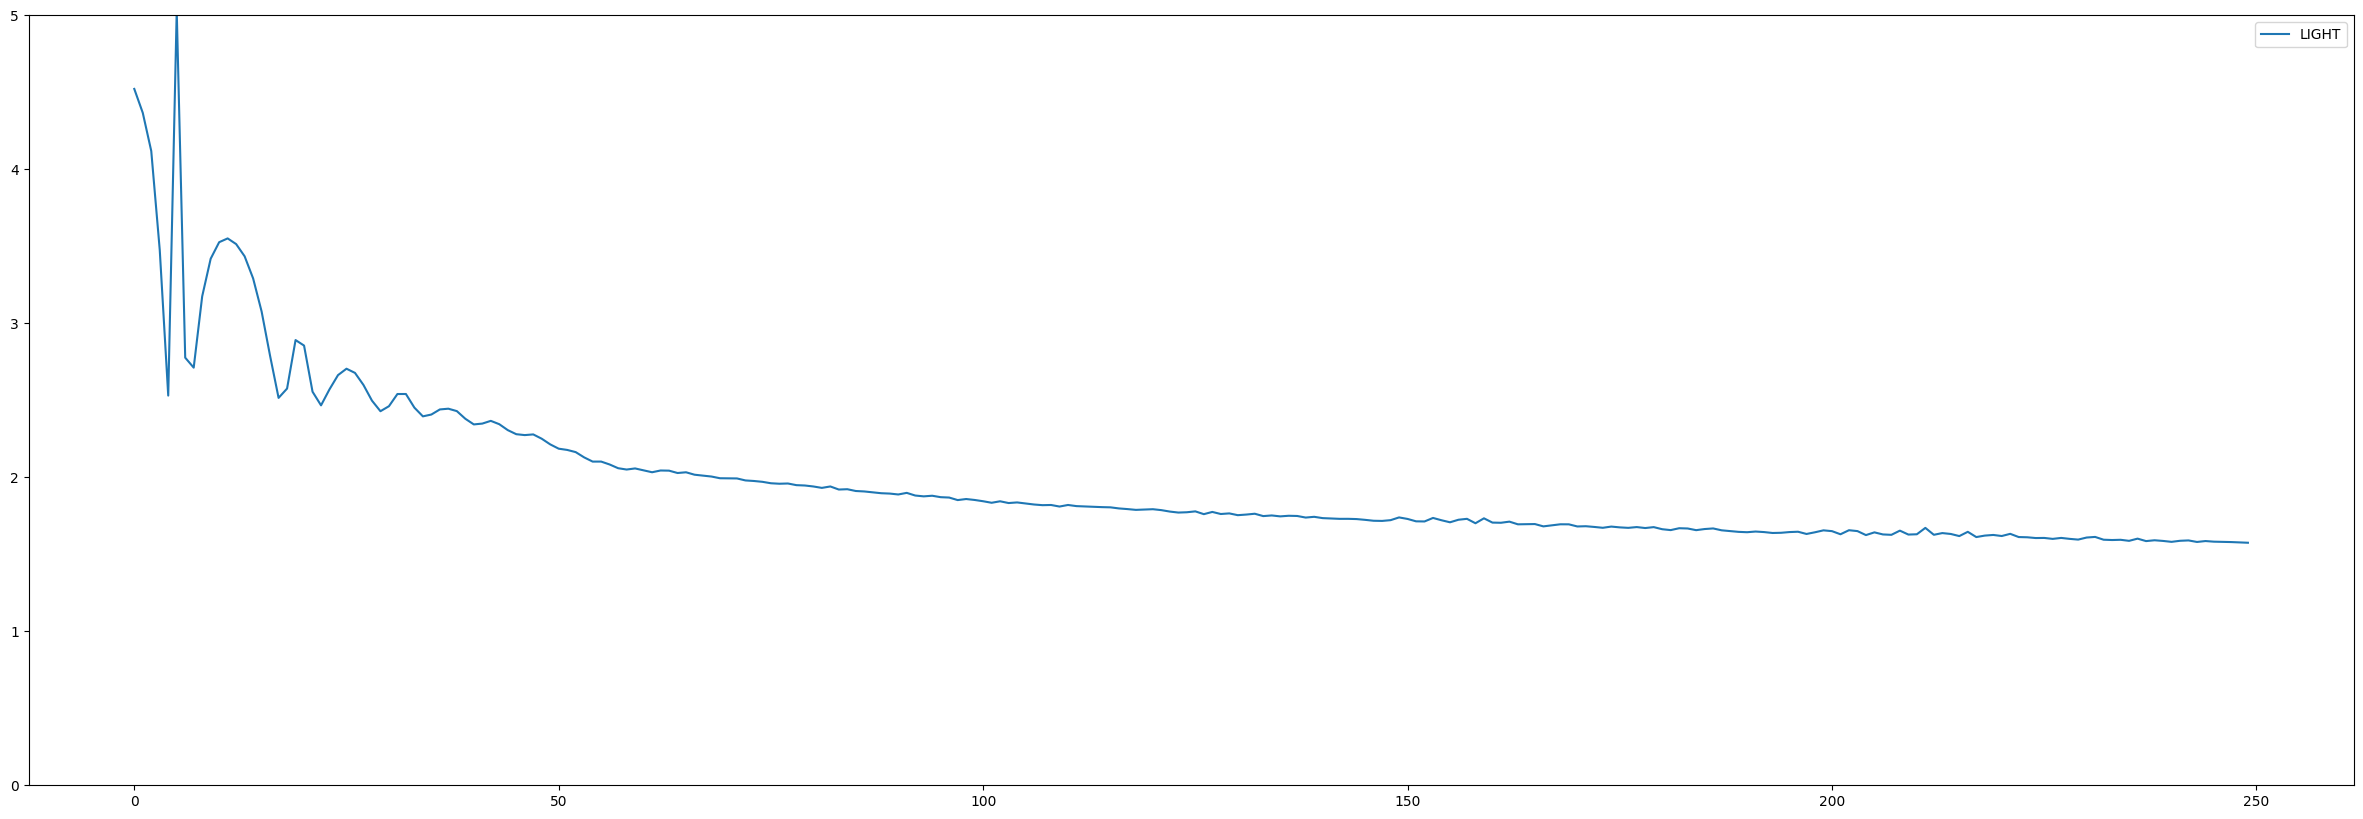

In [22]:
plot_loss(losses_, ylim=5)

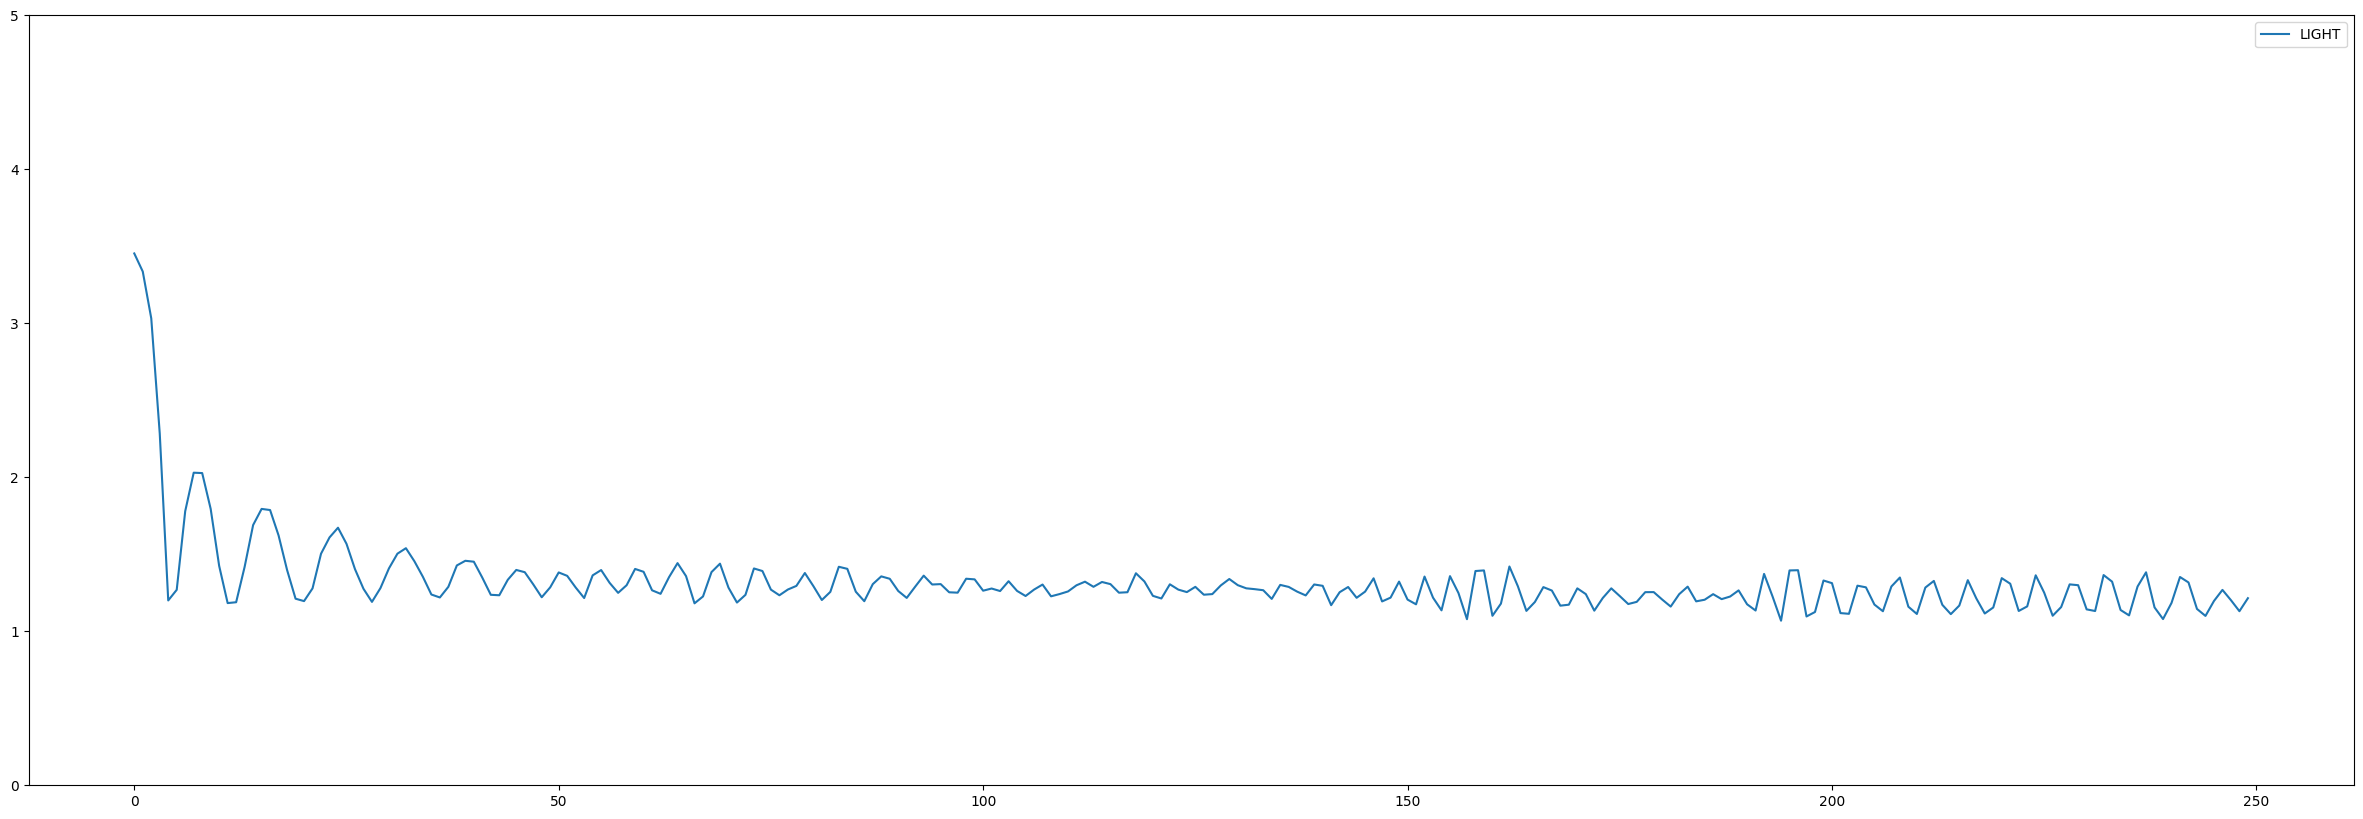

In [29]:
plot_test(losses_, ylim=5)

### Tests

In [24]:
pred = model(test_data.x_dict, test_data.edge_index_dict, test_data['user', 'movie'].edge_label_index)
pred = pred.clamp(min=0, max=5)

(array([ 129.,  303.,  374.,  480., 1042., 1942., 2175., 1901., 1159.,
         475.]),
 array([0.07672416, 0.56905174, 1.06137931, 1.55370688, 2.04603457,
        2.53836203, 3.03068972, 3.52301717, 4.01534462, 4.50767231,
        5.        ]),
 <BarContainer object of 10 artists>)

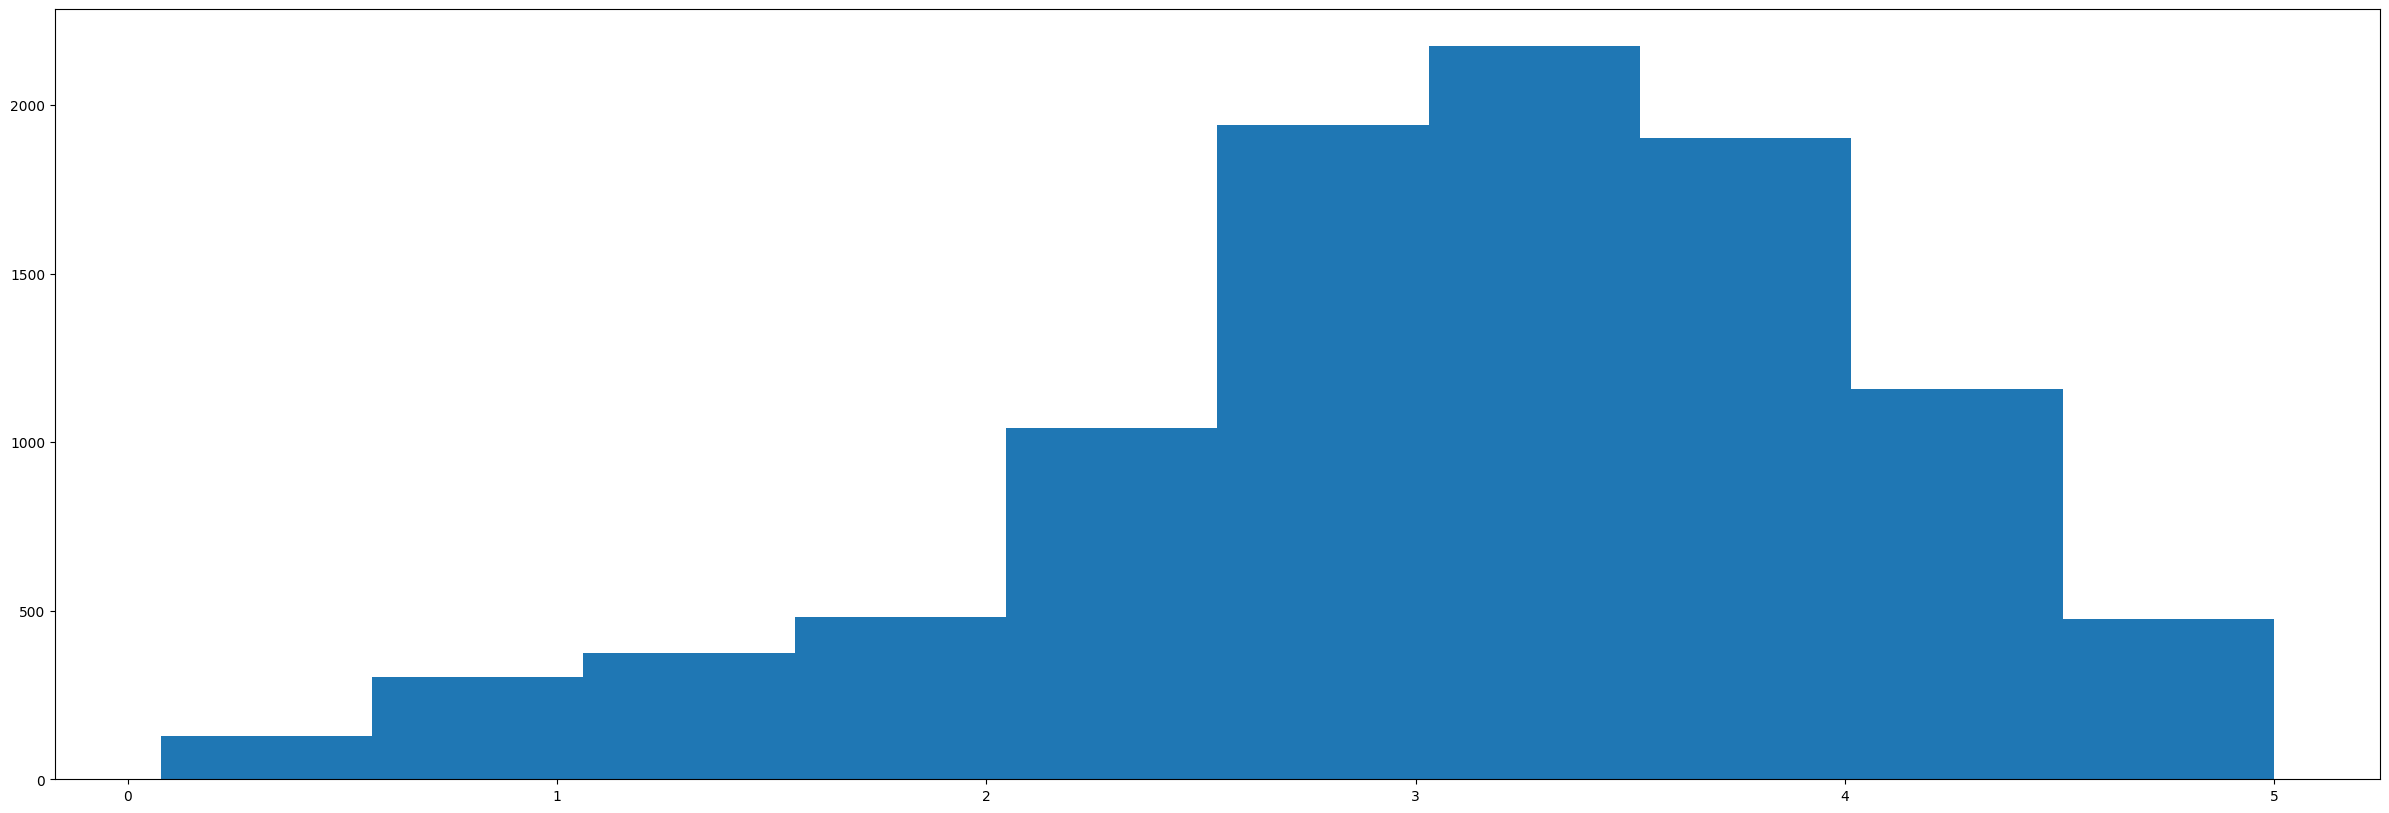

In [25]:
import matplotlib.pyplot as plt
predictions = pred.detach().numpy()
plt.hist(predictions)